2025-04-18 15:04:43.223455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-18 15:04:43.223491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-18 15:04:43.224772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 15:04:43.230998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-18 15:04:43.901432: W tensorflow/compiler/tf2

Files already downloaded and verified
Files already downloaded and verified
Initializing Swin-Small from scratch...
Total Parameters: 48,914,158
Trainable Parameters: 48,914,158

Model Complexity:
MACs: 8.77 GMac | FLOPs: 2*8.77 GMac | Params: 48.91 M


Validation: 100%|█████████████████████████████| 313/313 [00:33<00:00,  9.29it/s]


Epoch [1/5] Train Loss: 3.9647 | Val Loss: 3.5569 | Val Accuracy: 15.43% | Time: 438.21s


Validation: 100%|█████████████████████████████| 313/313 [00:33<00:00,  9.46it/s]


Epoch [2/5] Train Loss: 3.2964 | Val Loss: 3.1363 | Val Accuracy: 23.32% | Time: 432.66s


Validation: 100%|█████████████████████████████| 313/313 [00:33<00:00,  9.44it/s]


Epoch [3/5] Train Loss: 2.8694 | Val Loss: 2.7082 | Val Accuracy: 31.70% | Time: 430.49s


Validation: 100%|█████████████████████████████| 313/313 [00:31<00:00,  9.83it/s]


Epoch [4/5] Train Loss: 2.5262 | Val Loss: 2.4789 | Val Accuracy: 36.33% | Time: 429.69s


Validation: 100%|█████████████████████████████| 313/313 [00:32<00:00,  9.61it/s]


Epoch [5/5] Train Loss: 2.2333 | Val Loss: 2.2692 | Val Accuracy: 40.46% | Time: 425.35s

Evaluating final model on test set...


Validation: 100%|█████████████████████████████| 313/313 [00:32<00:00,  9.60it/s]


Final Test Accuracy: 40.46%


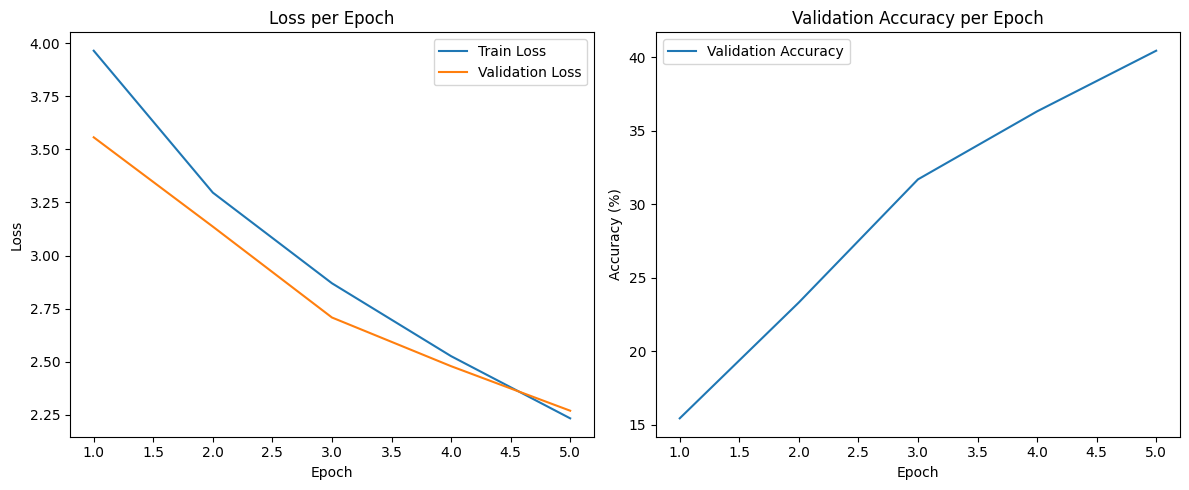

Total Training Time: 2156.40 seconds


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from transformers import SwinForImageClassification, SwinConfig, AutoImageProcessor
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from torchinfo import summary
from ptflops import get_model_complexity_info

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()


# Hyperparameters
num_epochs = 5
batch_size = 32
learning_rate = 2e-5
image_size = 224  

# Load the processor for normalization
processor = AutoImageProcessor.from_pretrained("microsoft/swin-small-patch4-window7-224")

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Load CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                             download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


config = SwinConfig.from_pretrained("microsoft/swin-small-patch4-window7-224")
config.num_labels = 100 


model = SwinForImageClassification(config).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Tracking metrics
train_losses = []
val_losses = []
val_accuracies = []
train_times = []

# Training loop
def train():
    model.train()
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]')

        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = running_loss / total_step
        train_losses.append(avg_train_loss)

        val_loss, val_accuracy = validate()
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_time = time.time() - start_time
        train_times.append(epoch_time)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}% | Time: {epoch_time:.2f}s')

# Validation loop
def validate():
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(test_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        accuracy = 100 * correct / total
        return avg_val_loss, accuracy

# Main execution
if __name__ == '__main__':
    print("Initializing Swin-Small from scratch...")
    info = summary(model, input_size=(batch_size, 3, image_size, image_size), device=device, verbose=0)
    print(f"Total Parameters: {info.total_params:,}")
    print(f"Trainable Parameters: {info.trainable_params:,}")

    macs, params = get_model_complexity_info(model, (3, image_size, image_size), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f"\nModel Complexity:\nMACs: {macs} | FLOPs: 2*{macs} | Params: {params}")

    train()

    print("\nEvaluating final model on test set...")
    val_loss, val_accuracy = validate()
    print(f'Final Test Accuracy: {val_accuracy:.2f}%')

    # Plot losses and accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Total Training Time: {sum(train_times):.2f} seconds")
